In [201]:
import numpy as np
from matplotlib import pyplot as plt
import math
import sys, os

# Oscillators


In [202]:
## Input data from data sheets
# each element will be [power, stability, frequency]
## ignore frequency tolerance, assuming we can compensate for this once and be done, otherwise relying on osc. stability
# low_f = 0-1Mhz (but actually, 32.768kHz), med_f = 1-20MHz, high_f = 20+ MHz
## May choose to show scatter of power/frequency vs. stability, since power and frequency have a direct (¿nearly linear?) relation
k = 1e3
M = 1e6
m=1/k
u=1/M
ppm=1e-6
ppb=1e-9 
# crystal resonators are awkward; we have to worry about the power of the resonance circuit, which the xtal iself knows nothing about
## I am using the Atmel D51 as my reference for the power consumption of that resonator circuit
xtal_low_f = np.asarray([[1.5e-6, 20e-6, 32768]]) #all xtals pretty consistently. Max 1uW drive level, 20-30ppm
xtal_med_f = np.asarray([[430*u, 20e-6, 8e6], [1.31*m, 20e-6, 16e6]])
xtal_high_f = np.asarray([[2.2*m, 20e-6, 32e6], [2.7*m, 20e-6, 48e6]])


#crystal oscillators. These contain the resonator circuit within. These power values are not always... sensical. Often stated as max ratings and/or with the assumption that the load will have some nontrivial (i.e. low) impedance
xo_low_f = np.asarray([[120e-6, 25e-6, 32768], [20e-6, 100e-6, 32768], [10e-6, 25e-6, 32768] , [10e-6, 10e-6, 32768]])
# xo_med_f = np.asarray([[23e-3, 50e-6, 20e6], [2.5e-3, 20e-6, 10e6], [2.5e-3, 25e-6, 10e6], [10e-3, 25e-6, 20e6], [10e-6, 20e-6, 1e6], [25e-3, 20e-6, 20e6]])
xo_med_f = np.asarray([[2.5e-3, 20e-6, 10e6], [2.5e-3, 25e-6, 10e6], [10e-3, 25e-6, 20e6], [10e-3, 20e-6, 1e6]])
xo_high_f = np.asarray([[12e-3, 20e-6, 26e6], [20*m, 20*ppm, 40*M], [25*m, 20*ppm, 60*M], [4.4*m, 25*ppm, 30*M], [6.5*m, 25*ppm, 50*M], [20*m, 25*ppm, 50*M], [30*m, 25*ppm,67*M], [20*m, 20*ppm, 20*M], [30*m, 20*ppm, 80*M], [20*m, 20*ppm, 25*M]])

#mems based oscillators. There's very little difference in most cases. Generally 10-25ppm. 
##The power has a very slight slope, but a noteworthy fixed offset. More bang for buck (Ampere) at higher frequency in MEMS, based on datasheet
mo_low_f = np.asarray([[1.3*u, 75*ppm, 32768]]) #very few options here (all from abracon/sitime). Not popular
mo_med_f = np.asarray([[2*m, 25*ppm, 1*M], [3*m, 25*ppm, 20*M], [3.8*m, 20*ppm, 20*M], [5*m, 10*ppm, 20*M], [6*m, 10*ppm, 1*M]])
# mo_med_f.append([[.55*m, .02, 1*M], [1.7*m, .02, 4*M], [3.2*m, .02, 8*M]]) #this is from a MEMS oscillator without PLL (MAX7375). Really bad stability. Probably a bad example
mo_high_f = np.asarray([[4*m, 25*ppm, 40*M], [5*m, 25*ppm, 80*M], [2.6*m, 25*ppm, 40*M], [6*m, 10*ppm, 20*M], [30*m, 10*ppm, 125*M], [4*m, 25*ppm, 40*M], [6.5*m, 10*ppm, 27*M], [7.2*m, 10*ppm, 70*M], [8.3*m, 10*ppm, 150*M]])

#TCXO's. #NB: These power readings are shockingly low, given they have more complexity than XTAL, XO, and MO
tcxo_low_f = np.asarray([[2*u, 5*ppm, 32768], [3*u, 5*ppm, 32768], [3*u, 5*ppm, 32768]])
# tcxo_med_f = np.asarray([[3*m, 100*ppb, 10*M], [2*m, 2.5*ppm, 20*M], [2*m, 2*ppm, 13*M], [6*m, 2.5*ppm, 20*M], [6*m, 2.5*ppm, 20*M]])
# tcxo_high_f = np.asarray([[5.5*m, 100*ppb, 40*M], [2.5*m, 2*ppm, 52*M], [4*m, 2.5*ppm, 28*M], [5*m, 2.5*ppm, 40*M], [5.5*m, 4*ppm, 30*M], [6*m, 4*ppm, 40*M], [7*m, 4*ppm, 54*M]])
tcxo_med_f = np.asarray([[7.8*m, 200*ppb, 10*M], [8.7*m, 100*ppb, 16*M], [5*m, 2.5*ppm, 20*M], [5*m, 2*ppm, 13*M], [6*m, 2.5*ppm, 20*M]])
tcxo_high_f = np.asarray([[13.7*m, 100*ppb, 51*M], [4*m, 2*ppm, 52*M], [6*m, 2.5*ppm, 28*M], [7*m, 2.5*ppm, 40*M], [7*m, 4*ppm, 30*M], [6*m, 4*ppm, 40*M], [8*m, 4*ppm, 54*M]])

#OCXO's. Low frequency OCXO does not really exist. Actually, they're pretty much all at the 10MHz range, and the frequency plays a small role in the power consumption since the main draw is from heating an oven. Assume 10MHz for simplicity. Power listed in Watts intead of current; i assume 3.3V as VCC
# ocxo_low_f = [[]]
ocxo_med_f = np.asarray([[300*m, 30*ppb, 10*M], [1.6/3.3, 10*ppb, 10*M], [1.3/3.3, 10*ppb, 10*M], [1.5/3.3, 10*ppb, 10*M]])
# ocxo_high_f = [[]]
#generally has .5-2 e-11 stability at t=1 on alan deviation plot. Good stability at low allan deviation time, but worsens with time

#SAW. Generally only high frequency output. Uses a crystal for the base output, usually
saw_high_f = np.asarray([[35*m, 50*ppm, 150*M], [25*m, 150*ppm, 250*M], [4*m, 25*ppm, 12*M], [50*m, 50*ppm, 170*M]])


#CSAC. There is only one that is commercially produced (to my knowledge). It produces 1PPS and 10 (or 16.384) MHz outputs
csac_med_f = np.asarray([[120*m/3.3, 10e-12, 10*M]]) #ppt. nuts. 3e-10 stability at t=1 seconds (part of alan deviation)
#CSAC seems objectively better than OCXO in long term stability. Worse jitter.

# labels = ['XTAL', 'XO', 'MO', 'TCO/TCXO', 'OCO/OCXO', 'SAW', 'CSAC']

In [203]:
#average data; too confusing to have all of the points on the same plot... it's just too much

xtal_low_f_av = xtal_low_f
xtal_med_f_av = np.average(xtal_med_f, axis=0)
xtal_high_f_av = np.average(xtal_high_f, axis=0)

xo_low_f_av = np.average(xo_low_f, axis=0)
xo_med_f_av = np.average(xo_med_f, axis=0)
xo_high_f_av = np.average(xo_high_f, axis=0)

mo_low_f_av = np.average(mo_low_f, axis=0)
mo_med_f_av = np.average(mo_med_f, axis=0)
mo_high_f_av = np.average(mo_high_f, axis=0)

tcxo_low_f_av = np.average(tcxo_low_f, axis=0)
tcxo_med_f_av = np.average(tcxo_med_f, axis=0)
tcxo_high_f_av = np.average(tcxo_high_f, axis=0)

ocxo_med_f_av = np.average(ocxo_med_f, axis=0)

saw_high_f_av = np.average(saw_high_f, axis=0)

csac_med_f_av = np.average(csac_med_f, axis=0)


In [204]:
# xtal = np.asarray(xtal_low_f + xtal_med_f + xtal_high_f)
# xo = np.asarray(xo_low_f + xo_med_f + xo_high_f)
# mo = np.asarray(mo_low_f + mo_med_f + mo_high_f)
# tco = np.asarray(tcxo_low_f + tcxo_med_f + tcxo_high_f)
# oco = np.asarray(ocxo_med_f)
# saw = np.asarray(saw_high_f)
# csac = np.asarray(csac_med_f)

# print(np.append( xtal_med_f, np.asarray([['blue', '.'] for i in range(xtal_med_f.shape[0])]) , axis=-1 ))

# xtal_low_f_plt = np.append( xtal_low_f, np.asarray([['mediumseagreen', '.'] for i in range(xtal_low_f.shape[0])]) , axis=-1)
# xtal_med_f_plt = np.append( xtal_med_f, np.asarray([['blue', '.'] for i in range(xtal_med_f.shape[0])]) , axis=-1)
# xtal_high_f_plt = np.append( xtal_high_f, np.asarray([['red', '.'] for i in range(xtal_high_f.shape[0])]) , axis=-1)

# xo_low_f_plt = np.append( xo_low_f, np.asarray([['mediumseagreen', 'x'] for i in range(xo_low_f.shape[0])]) , axis=-1)
# xo_med_f_plt = np.append( xo_med_f, np.asarray([['blue', 'x'] for i in range(xo_med_f.shape[0])]) , axis=-1)
# xo_high_f_plt = np.append( xo_high_f, np.asarray([['red', 'x'] for i in range(xo_high_f.shape[0])]) , axis=-1)

# mo_low_f_plt = np.append( mo_low_f, np.asarray([['mediumseagreen', '+'] for i in range(mo_low_f.shape[0])]) , axis=-1)
# mo_med_f_plt = np.append( mo_med_f, np.asarray([['blue', '+'] for i in range(mo_med_f.shape[0])]) , axis=-1)
# mo_high_f_plt = np.append( mo_high_f, np.asarray([['red', '+'] for i in range(mo_high_f.shape[0])]) , axis=-1)

# tcxo_low_f_plt = np.append( tcxo_low_f, np.asarray([['mediumseagreen', '*'] for i in range(tcxo_low_f.shape[0])]) , axis=-1)
# tcxo_med_f_plt = np.append( tcxo_med_f, np.asarray([['blue', '*'] for i in range(tcxo_med_f.shape[0])]) , axis=-1)
# tcxo_high_f_plt = np.append( tcxo_high_f, np.asarray([['red', '*'] for i in range(tcxo_high_f.shape[0])]) , axis=-1)

# ocxo_med_f_plt = np.append( ocxo_med_f, np.asarray([['blue', 'v'] for i in range(ocxo_med_f.shape[0])]) , axis=-1)

# saw_high_f_plt = np.append( saw_high_f, np.asarray([['red', 'd'] for i in range(saw_high_f.shape[0])]) , axis=-1)

# csac_med_f_plt = np.append( csac_med_f, np.asarray([['blue', 's'] for i in range(csac_med_f.shape[0])]) , axis=-1)

xtal_low_f_plt = np.append( xtal_low_f_av[0], np.asarray(['mediumseagreen', '.'] ) , axis=-1)
xtal_med_f_plt = np.append( xtal_med_f_av, np.asarray(['blue', '.']) , axis=-1)
xtal_high_f_plt = np.append( xtal_high_f_av, np.asarray(['red', '.']) , axis=-1)

xo_low_f_plt = np.append( xo_low_f_av, np.asarray(['mediumseagreen', 'x'] ) , axis=-1)
xo_med_f_plt = np.append( xo_med_f_av, np.asarray(['blue', 'x'] ) , axis=-1)
xo_high_f_plt = np.append( xo_high_f_av, np.asarray(['red', 'x'] ) , axis=-1)

mo_low_f_plt = np.append( mo_low_f_av, np.asarray(['mediumseagreen', '+']) , axis=-1)
mo_med_f_plt = np.append( mo_med_f_av, np.asarray(['blue', '+'] ) , axis=-1)
mo_high_f_plt = np.append( mo_high_f_av, np.asarray(['red', '+'] ) , axis=-1)

tcxo_low_f_plt = np.append( tcxo_low_f_av, np.asarray(['mediumseagreen', '*'] ) , axis=-1)
tcxo_med_f_plt = np.append( tcxo_med_f_av, np.asarray(['blue', '*'] ) , axis=-1)
tcxo_high_f_plt = np.append( tcxo_high_f_av, np.asarray(['red', '*'] ) , axis=-1)

ocxo_med_f_plt = np.append( ocxo_med_f_av, np.asarray(['blue', 'v'] ) , axis=-1)

saw_high_f_plt = np.append( saw_high_f_av, np.asarray(['red', 'd'] ) , axis=-1)

csac_med_f_plt = np.append( csac_med_f_av, np.asarray(['blue', 's'] ) , axis=-1)


Text(0.5, 1.0, 'Current at 3.3V Vs. Oscillator Stability')

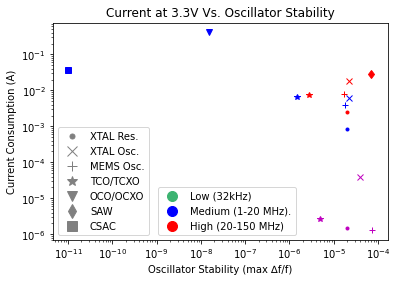

In [205]:

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = plt.subplots()

#markers: https://matplotlib.org/stable/api/markers_api.html#module-matplotlib.markers
# plt.scatter(xtal[:,1], xtal[:,0], marker='.', c='blue')
# plt.scatter(xo[:,1], xo[:,0], marker='x', c='orange')
# plt.scatter(mo[:,1], mo[:,0], marker='s', c='black')
# plt.scatter(tco[:,1], tco[:,0], marker='v', c='red')
# plt.scatter(oco[:,1], oco[:,0], marker='+', c='olive')
# plt.scatter(saw[:,1], saw[:,0], marker='d', c='brown')
# plt.scatter(csac[:,1], csac[:,0], marker='*', c='magenta')

# plt.scatter(xtal[:,1], xtal[:,0]/xtal[:,2], marker='.', c='blue')
# plt.scatter(xo[:,1], xo[:,0]/xo[:,2], marker='x', c='orange')
# plt.scatter(mo[:,1], mo[:,0]/mo[:,2], marker='s', c='black')
# plt.scatter(tco[:,1], tco[:,0]/tco[:,2], marker='v', c='red')
# plt.scatter(oco[:,1], oco[:,0]/oco[:,2], marker='+', c='olive')
# plt.scatter(saw[:,1], saw[:,0]/saw[:,2], marker='d', c='brown')
# plt.scatter(csac[:,1], csac[:,0]/csac[:,2], marker='*', c='magenta')

#low frequency use red, medium use blue, high use black

#xtal use '.' marker, 
# print(xtal_med_f_plt)
pxtl, = plt.plot(xtal_low_f_plt[1].astype('float'), xtal_low_f_plt[0].astype('float'), c=xtal_low_f_plt[3][0], marker=xtal_low_f_plt[4][0] )
pxtm,  = plt.plot(xtal_med_f_plt[1].astype('float'), xtal_med_f_plt[0].astype('float'), c=xtal_med_f_plt[3][0], marker=xtal_med_f_plt[4][0] )
pxth, = plt.plot(xtal_high_f_plt[1].astype('float'), xtal_high_f_plt[0].astype('float'), c=xtal_high_f_plt[3][0], marker=xtal_high_f_plt[4][0] )

pxl, = plt.plot(xo_low_f_plt[1].astype('float'), xo_low_f_plt[0].astype('float'), c=xo_low_f_plt[3][0], marker=xo_low_f_plt[4][0] )
pxm, = plt.plot(xo_med_f_plt[1].astype('float'), xo_med_f_plt[0].astype('float'), c=xo_med_f_plt[3][0], marker=xo_med_f_plt[4][0] )
pxh, = plt.plot(xo_high_f_plt[1].astype('float'), xo_high_f_plt[0].astype('float'), c=xo_high_f_plt[3][0], marker=xo_high_f_plt[4][0] )

pml, = plt.plot(mo_low_f_plt[1].astype('float'), mo_low_f_plt[0].astype('float'), c=mo_low_f_plt[3][0], marker=mo_low_f_plt[4][0] )
pmm, = plt.plot(mo_med_f_plt[1].astype('float'), mo_med_f_plt[0].astype('float'), c=mo_med_f_plt[3][0], marker=mo_med_f_plt[4][0] )
pmh, = plt.plot(mo_high_f_plt[1].astype('float'), mo_high_f_plt[0].astype('float'), c=mo_high_f_plt[3][0], marker=mo_high_f_plt[4][0] )

ptl, = plt.plot(tcxo_low_f_plt[1].astype('float'), tcxo_low_f_plt[0].astype('float'), c=tcxo_low_f_plt[3][0], marker=tcxo_low_f_plt[4][0] )
ptm, = plt.plot(tcxo_med_f_plt[1].astype('float'), tcxo_med_f_plt[0].astype('float'), c=tcxo_med_f_plt[3][0], marker=tcxo_med_f_plt[4][0] )
pth, = plt.plot(tcxo_high_f_plt[1].astype('float'), tcxo_high_f_plt[0].astype('float'), c=tcxo_high_f_plt[3][0], marker=tcxo_high_f_plt[4][0] )

pom, = plt.plot(ocxo_med_f_plt[1].astype('float'), ocxo_med_f_plt[0].astype('float'), c=ocxo_med_f_plt[3][0], marker=ocxo_med_f_plt[4][0] )

psh, = plt.plot(saw_high_f_plt[1].astype('float'), saw_high_f_plt[0].astype('float'), c=saw_high_f_plt[3][0], marker=saw_high_f_plt[4][0] )

pcm, = plt.plot(csac_med_f_plt[1].astype('float'), csac_med_f_plt[0].astype('float'), c=csac_med_f_plt[3][0], marker=csac_med_f_plt[4][0] )


legend_types = [Line2D([0], [0],  color='w', marker='.', label='XTAL Res.', markersize=10, markerfacecolor='grey', markeredgecolor='grey'),
                    Line2D([0], [0], color='w', marker='x', label='XTAL Osc.', markersize=10, markerfacecolor='grey', markeredgecolor='grey'),
                    Line2D([0], [0], color='w', marker='+', label='MEMS Osc.', markersize=10, markerfacecolor='grey', markeredgecolor='grey'),
                    Line2D([0], [0], color='w', marker='*', label='TCO/TCXO', markersize=10, markerfacecolor='grey', markeredgecolor='grey'),
                    Line2D([0], [0], color='w', marker='v', label='OCO/OCXO', markersize=10, markerfacecolor='grey', markeredgecolor='grey'),
                    Line2D([0], [0], color='w', marker='d', label='SAW', markersize=10, markerfacecolor='grey', markeredgecolor='grey'),
                    Line2D([0], [0], color='w', marker='s', label='CSAC', markersize=10, markerfacecolor='grey', markeredgecolor='grey')]

legend_frequencies = [Line2D([0], [0],  color='w', marker='o', label='Low (32kHz)', markersize=10, markerfacecolor='mediumseagreen', markeredgecolor='mediumseagreen'),
                    Line2D([0], [0], color='w', marker='o', label='Medium (1-20 MHz).', markersize=10, markerfacecolor='blue', markeredgecolor='blue'),
                    Line2D([0], [0], color='w', marker='o', label='High (20-150 MHz)', markersize=10, markerfacecolor='red', markeredgecolor='red')]


ax.set_xscale('log')
ax.set_yscale('log')
plt.ylabel('Current Consumption (A)')
plt.xlabel('Oscillator Stability (max ∆f/f)')

# leg = plt.legend([(pxtl, pxtm, pxth), (pxl, pxm, pxh), (pml, pmm, pmh), (ptl, ptm, pth), (pom), (psh), (pcm)], ['XTAL', 'XO', 'MO', 'TCO/TCXO', 'OCO/OCXO', 'SAW', 'CSAC'])
# l_types = ax.legend(handles=legend_types, bbox_to_anchor=(1,1), loc='upper left')
# l_frequncies = ax.legend(handles=legend_frequencies, bbox_to_anchor=(1,0), loc='lower left')
l_types = ax.legend(handles=legend_types, loc='lower left')
l_frequncies = ax.legend(handles=legend_frequencies, bbox_to_anchor=(.3,0), loc='upper left')
ax.add_artist(l_types)

# plt.legend(['XTAL', 'XO', 'MO', 'TCO/TCXO', 'OCO/OCXO', 'SAW', 'CSAC'], bbox_to_anchor = (1,1), loc='upper left')
# https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph 
plt.title('Current at 3.3V Vs. Oscillator Stability')

# Radios


# Power Model

In [350]:
def num_messages(sync_tolerance, sync_accuracy, radio_bandwidth):
    '''
    return the number of messages needed to achieve the specified accuracy, assuming that it is alrady synchronized to the sync_tolerance, which should be the case in the **steady state**.
    If you want the number of messages, assuming we are not already sycnrhonized, then set the sync_tolerance to infinity
    '''
    n_msgs = 1
    if 1/radio_bandwidth > sync_accuracy:
            if (sync_accuracy > sync_tolerance):
                tmp = num_messages_first(sync_tolerance, radio_bandwidth)
            else:
                tmp = (1/sync_accuracy**2 - 1/sync_tolerance**2)/(radio_bandwidth**2)
            # tmp = (1/sync_acc**2)/radio_bandwidth**2
            if math.isinf(tmp):
                tmp = sys.maxsize
            n_msgs = int(math.ceil(tmp+1e-20)) #add epsilon in case floating points get too low and act weird.
    try:
        assert(n_msgs > 0)
    except AssertException:
        return int(sys.maxsize)


    return n_msgs

def num_messages_first(sync_accuracy, radio_bandwidth):
    n_msgs = 1
    if 1/radio_bandwidth > sync_accuracy:
            tmp = 1/((sync_accuracy**2)*(radio_bandwidth**2))
            # tmp = (1/sync_acc**2)/radio_bandwidth**2
            if math.isinf(tmp):
                tmp = sys.maxsize
            n_msgs = int(math.ceil(tmp+1e-20)) #add epsilon in case floating points get too low and act weird.
            
    assert(n_msgs > 0)

    return n_msgs



def power_of_sync(sync_tolerance, osc_stability, osc_power, osc_frequency, radio_bandwidth, radio_datarate_tx, radio_datarate_rx, radio_power_tx, radio_power_rx, radio_power_stby, radio_time_stby, proc_power_sleep, proc_power_active, num_sync_msg_bytes=50, plot_acc_vs_tol=False):
    '''
    Assumptions: 
        no packets are dropped
        the oscillator's stability rating is the worst case, and while it may be better at runtime, we need to plan for the best to ensure we're synchronized accurately; we cannot check without synchronizing in the process, so we have to assume something here
        radio datarate is the same for uplink and downlink
        A synchronization packet is about 50 bytes long. This tells us the time on air, given the data rate. 50 bytes is overprovisioned such that space for preamble and header can be subsumed into that 50 bytes
        The synchronization tolerance is actually the standard deviation of a guassian; if the user wants to be , for isntance, 96% confident that this is within those bounds, then they should multiply tolerance by the z-score that would achieve that confidence interval; for 96%, that value is z=2.
    '''

    if sync_tolerance < 1/osc_frequency:
        # print(f"You cannot synchronize within ±{sync_tolerance}, which is more precise than the resolution (1/f) of your oscillator running at {osc_frequency} Hz!") # at least, not without doing something clever like VHT. I, a big fat meanie, assume the user is not clever
        return sys.maxsize, sys.maxsize, sys.maxsize,sync_tolerance

    sync_accuracy = np.logspace(math.log10(1/radio_bandwidth/100), math.log10(sync_tolerance), num=200)
    n_msgs = np.ones(sync_accuracy.shape, dtype='int')

    max_realizable = 0

    for i, s_a in enumerate(sync_accuracy):
        n_msgs[i] = num_messages(sync_tolerance, s_a, radio_bandwidth)
        if n_msgs[i] == sys.maxsize:
            max_realizable = i
        n_msgs[i] = int(n_msgs[i])
        

    # plt.semilogy(sync_accuracy, n_msgs, 'r*')
    # plt.ylim(0,n_msgs[max_realizable]+1)
    # plt.show()


    tx_time = num_sync_msg_bytes / radio_datarate_tx
    tx_energy = tx_time * (radio_power_tx + proc_power_active - proc_power_sleep) #Joules. assuming the processor has to be active during this time. 

    rx_time = num_sync_msg_bytes / radio_datarate_rx
    rx_energy = rx_time * (radio_power_rx + proc_power_active - proc_power_sleep) #Joules. assuming the processor has to be active during this time

    stby_energy = radio_time_stby * radio_power_stby #Joules. assuming the processor may be asleep during this time

    energy_per_sync = tx_energy + rx_energy + stby_energy

    resync_interval = 1/osc_stability * (sync_tolerance - sync_accuracy) #period between resynchronization
    resync_interval = 1/osc_stability * (sync_tolerance -  (1/np.sqrt(n_msgs) * 1/radio_bandwidth)) #period between synchronizations should be based on how precisely we actually synchornize, not how accurately we *intended* to synchronize
    resync_time = n_msgs * (tx_time + rx_time + radio_time_stby) #how long it takes to do the synchronization. Assume no wait time between, no possibility for network contention

    # number of messages sent per second; normalize the number of messages by the periodicity at which the clock must resynchronize
    msgs_per_unit_time = n_msgs / resync_interval
    msgs_per_unit_time[np.isinf(msgs_per_unit_time)] = sys.maxsize
    msgs_per_unit_time[resync_time > resync_interval] = sys.maxsize #if it takes longer to synchronize than desynchronize, then this configuration is not feasible


    maintenance_power = osc_power + proc_power_sleep #the power consummed while keeping the clock running 
    sync_power = msgs_per_unit_time*energy_per_sync
    total_clock_power = maintenance_power + sync_power

    if plot_acc_vs_tol:
        plt.figure()
        plt.loglog(sync_accuracy, total_clock_power, 'r')
        plt.loglog(sync_accuracy, sync_power, 'k')
        plt.loglog(sync_accuracy, maintenance_power, 'b')

        plt.title('Synchronization Power vs. Sub-Tolerance Accuracy \nNormalized to One Synchronization Interval')
        plt.xlabel('Synchronization Accuracy (0 to tolerance) [s]')
        plt.ylabel('Power [W]')
        plt.ylim(0, radio_power_tx+radio_power_rx+proc_power_active)
        plt.legend(['Total Clock Power', 'Power to synchronize', 'Power to maintain'])
        # print(np.asarray([sync_accuracy, n_msgs, msgs_per_unit_time, resync_time]).T)

        plt.show()
        plt.waitforbuttonpress()

    optimal_index = np.argmin(total_clock_power) #this really isn't that meaningful, but we'll use the outcome to generate more info in the future
    best_sync_acc = sync_accuracy[optimal_index]
    best_power = total_clock_power[optimal_index]
    best_sync_power = sync_power[optimal_index]
    best_osc_power = maintenance_power

    # print(n_msgs[optimal_index])
    print(best_sync_acc)

    return best_power, best_sync_power, best_osc_power, best_sync_acc

def battery_life_coach(battery_mah, average_app_power, power_of_sync, vdd=3.3):
    '''
    For a given battery, tells you how long the battery will last, as well as the percentage of the battery that will go to clock synchronization
    ''' 
    battery_ah = battery_mah / 1000

    total_power = average_app_power + power_of_sync #well that's easy. This assumes we have an average reading for power consumption
    total_current = total_power / vdd

    battery_life = battery_ah * 3600 / total_current #in seconds
    percentage_for_sync = power_of_sync/total_power
    # print('synchronization accounts for %f percent of application power; app: %f W, sync: %f W' % (percentage_for_sync, average_app_power, power_of_sync))

    battery_life_days = battery_life / (3600*24)

    return battery_life_days, percentage_for_sync


In [351]:
hardware_config_str = '32kHz XTAL, WiFi, 1Ah batt, 200uA app current'
save_dir = './prelim_sync_power/'

# 1MHz crystal oscillator
# osc_stability = 1e-6  #unitless; ratio of offset/intended frequency
# osc_power = 3.3*500e-6 #test @ 0. #500e-6 * 3.3 # Watts
# osc_frequency = 1e6 #Hz

osc = xtal_low_f_av[0] #formatted as [current, ppm, frequency]
# osc = xtal_med_f_av
# osc = tcxo_med_f_av
# osc = [tcxo_low_f_av[0], 1e-6, tcxo_low_f_av[2]]
print(osc)

#lora; downlink bandwidth is the important variable
radio_bandwidth = 500e3 # Hz
radio_datarate_tx = 1e3 #bps
radio_datarate_rx = 1e3 #bps
radio_power_tx = 3.3*85e-3 #watts
radio_power_rx = 3.3*5e-3 #watts
radio_power_stby = 3.3*600e-9 #watts
radio_time_stby = 1 #seconds

#WiFi; downlink bandwidth is what I provide
radio_bandwidth = 20e6 # Hz
radio_datarate_tx = 50e6 #bps
radio_datarate_rx = 50e6 #bps
radio_power_tx = 3.3*200e-3 #watts
radio_power_rx = 3.3*75e-3 #watts
radio_power_stby = 3.3*10e-6 #watts
radio_time_stby = 50e-6 #seconds

#commonsense d51
proc_power_sleep = 3.3*10e-6 #watts
proc_power_active = 20e-3 * 3.3 #watts

sync_tol = np.logspace(-7,0, num=200)
total_power = np.zeros(sync_tol.shape)
maintenance_power = np.zeros(sync_tol.shape)
radio_power = np.zeros(sync_tol.shape)
battery_life = np.zeros(sync_tol.shape)
sync_percent_of_power = np.zeros(sync_tol.shape)


battery_size = 1000
application_power = 200e-6 *3.3 # estimate an application runs at 150 uA in the steady state, including all the duty cycling at such.

for i, s in enumerate(sync_tol):
    # print('Synchronize for LoRa parameters down to accuracy of ±%e seconds...' % s)
    # total_power[i],radio_power[i], maintenance_power[i], _ = power_of_sync(s, osc_stability, osc_power, osc_frequency, radio_bandwidth, radio_datarate_tx, radio_datarate_rx, radio_power_tx, radio_power_rx, radio_power_stby, radio_time_stby, proc_power_sleep, proc_power_active)
    total_power[i],radio_power[i], maintenance_power[i], _ = power_of_sync(s, osc[1], osc[0]*3.3, osc[2], radio_bandwidth, radio_datarate_tx, radio_datarate_rx, radio_power_tx, radio_power_rx, radio_power_stby, radio_time_stby, proc_power_sleep, proc_power_active, plot_acc_vs_tol=False)
    battery_life[i], sync_percent_of_power[i] = battery_life_coach(battery_size, application_power, total_power[i])

useful_ind = battery_life > 1e-10

plt.figure()
plt.loglog(sync_tol[useful_ind], total_power[useful_ind], 'k')
plt.loglog(sync_tol[useful_ind], maintenance_power[useful_ind], 'b')
plt.loglog(sync_tol[useful_ind], radio_power[useful_ind], 'r')
plt.ylim(0,2)
plt.title("Power Cost of Synchronization vs. Required Tolerance \n%s" % hardware_config_str)
plt.xlabel('Synchronization Tolerance [s]')
plt.ylabel('Power (W)')
plt.legend(['Total Power', 'Power of oscillator', 'Power of Wireless Sync'])

# plt.savefig(f'{save_dir}{hardware_config_str}_power.png')

fig, ax1 = plt.subplots()
plt.loglog(sync_tol[useful_ind], battery_life[useful_ind], 'r')
plt.title("Battery Lifetime vs. Required Tolerance \n %s" % hardware_config_str)
plt.xlabel('Synchronization Tolerance [s]')
ax1.set_ylabel('Battery Life (days)')
ax2 = ax1.twinx()
ax2.set_ylabel('Percentage of Battery Life')
ax2.semilogx(sync_tol[useful_ind], sync_percent_of_power[useful_ind],'b')
fig.legend(['Battery Lifetime', 'Percentage for Sync'], loc=(0.5, 0.5))
# ax2.legend(['Percentage of Battery for Sync'], loc='center right')
plt.gcf().subplots_adjust(left=.35, right=0.85) # sometimes part of the ylabel gets cut off

# plt.savefig(f'{save_dir}{hardware_config_str}_battery.png')


# print(total_power[-1])
# print(application_power)
# print(battery_life[-1])
# print(sync_tol[useful_ind][0])
# osc[0]*3.3

[1.5000e-06 2.0000e-05 3.2768e+04]


NameError: name 'BW' is not defined

In [312]:
x = np.linspace()

313043478.26086956
3623.1884057971015
